In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-support-ticket-dataset/customer_support_tickets.csv


In [3]:
df = pd.read_csv('/kaggle/input/customer-support-ticket-dataset/customer_support_tickets.csv')

# Drop rows with missing values (inplace=False by default, so it doesn't modify df in place)
df.dropna()


# Rename certain columns for consistency and easier access
df.rename(columns={'Ticket Status': 'Ticket_Status', 'Customer Gender': 'Customer_Gender', 
                   'Ticket Priority': 'Ticket_Priority', 'Ticket Type': 'Ticket_Type'}, inplace=True)

In [4]:
df.head(1).T

,0
Ticket ID,1
Customer Name,Marisa Obrien
Customer Email,carrollallison@example.com
Customer Age,32
Customer_Gender,Other
Product Purchased,GoPro Hero
Date of Purchase,2021-03-22
Ticket_Type,Technical issue
Ticket Subject,Product setup
Ticket Description,I'm having an issue with the {product_purchase...


In [5]:
df['Ticket Description'] = df.apply(lambda row: row['Ticket Description'].replace('{product_purchased}', row['Product Purchased']), axis=1)

<Axes: title={'center': 'Value Counts of Ticket Type'}, xlabel='Ticket Type', ylabel='Count'>

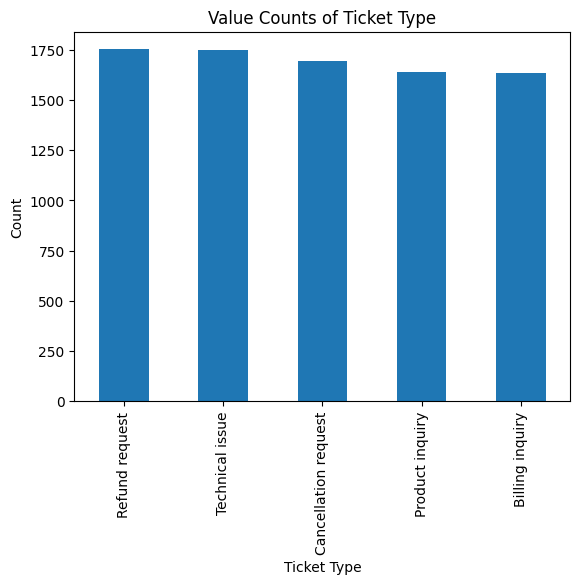

In [6]:
df["Ticket_Type"].value_counts().plot(kind='bar', title='Value Counts of Ticket Type', xlabel='Ticket Type', ylabel='Count')


In [7]:
labels = df["Ticket_Type"].unique()
labels

array(['Technical issue', 'Billing inquiry', 'Cancellation request',
       'Product inquiry', 'Refund request'], dtype=object)

In [8]:
from transformers import pipeline

In [9]:
model="google-bert/bert-base-uncased"

In [39]:
pipe = pipeline("zero-shot-classification", model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


# Zero shot prompting

## 4 out 5 are correct but the scores have minute difference in their decisions

#### Sample

In [11]:
inference_sample_ip = df["Ticket Description"].iloc[:5].tolist()
inference_sample_op = pipe(inference_sample_ip,labels, multi_label=True, return_all_scores = False)

In [12]:
[op['labels'][0] for op in inference_sample_op]

['Billing inquiry',
 'Product inquiry',
 'Technical issue',
 'Billing inquiry',
 'Technical issue']

#### Sample Data

In [13]:
sample_len = 10 
sampled_df = df.groupby('Ticket_Type', group_keys=False).apply(lambda x: x.sample(n=min(len(x), sample_len), replace=False)).reset_index(drop=True)

<Axes: title={'center': 'Value Counts of Ticket Type'}, xlabel='Ticket Type', ylabel='Count'>

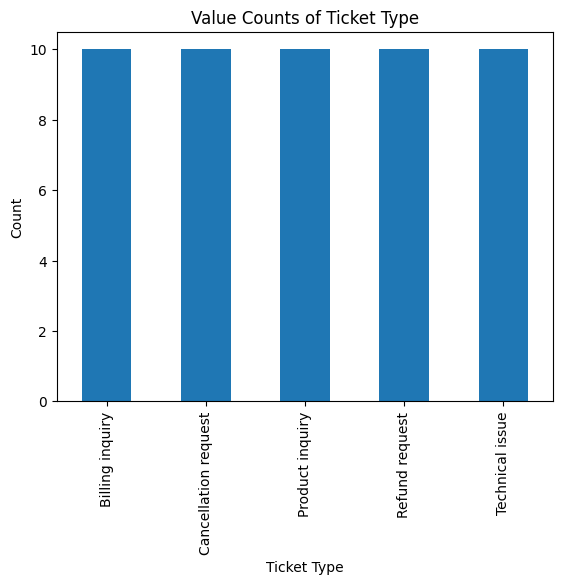

In [14]:
sampled_df["Ticket_Type"].value_counts().plot(kind='bar', title='Value Counts of Ticket Type', xlabel='Ticket Type', ylabel='Count')


In [15]:
from torch.utils.data import Dataset

class ListDataset(Dataset):
     def __init__(self, original_list):
        self.original_list = original_list
     def __len__(self):
        return len(self.original_list)

     def __getitem__(self, i):
        return self.original_list[i]

In [16]:
text_data = ListDataset(sampled_df["Ticket Description"].tolist())
text_data

In [24]:
sampled_df

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer_Gender,Product Purchased,Date of Purchase,Ticket_Type,Ticket Subject,Ticket Description,Ticket_Status,Resolution,Ticket_Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,6222,Regina Armstrong,colerobert@example.com,32,Male,Samsung Galaxy,2021-09-27,Billing inquiry,Battery life,I'm having an issue with the Samsung Galaxy. P...,Open,NaN,Critical,Phone,NaN,NaN,NaN
1,4154,Matthew Miller,bruce88@example.org,35,Female,Sony Xperia,2021-06-29,Billing inquiry,Product compatibility,I'm having an issue with the Sony Xperia. Plea...,Open,NaN,High,Email,NaN,NaN,NaN
2,7261,Sharon Russell,ann61@example.org,30,Female,Bose SoundLink Speaker,2021-12-29,Billing inquiry,Refund request,I'm having an issue with the Bose SoundLink Sp...,Pending Customer Response,NaN,High,Email,2023-06-01 10:57:15,NaN,NaN
3,1262,Caitlin Johnson,derek73@example.com,20,Female,Philips Hue Lights,2020-03-15,Billing inquiry,Delivery problem,I'm unable to access my Philips Hue Lights acc...,Open,NaN,High,Email,NaN,NaN,NaN
4,2614,Haley Franklin,alexhernandez@example.com,23,Other,Autodesk AutoCAD,2020-05-03,Billing inquiry,Battery life,I'm having an issue with the Autodesk AutoCAD....,Open,NaN,Critical,Email,NaN,NaN,NaN
5,5931,Thomas Brown,stephendavidson@example.net,47,Male,Garmin Forerunner,2021-09-11,Billing inquiry,Product compatibility,I'm having an issue with the Garmin Forerunner...,Closed,Water wish staff best my wall the church.,Low,Chat,2023-06-01 20:09:57,2023-06-01 22:42:57,4.0
6,7490,Katherine Collins,jorgerobbins@example.net,37,Male,Nintendo Switch Pro Controller,2020-10-19,Billing inquiry,Hardware issue,The Nintendo Switch Pro Controller is unable t...,Pending Customer Response,NaN,Low,Email,2023-06-01 08:40:46,NaN,NaN
7,5452,Rodney Johnson,ronniesmith@example.net,22,Other,Sony PlayStation,2020-06-21,Billing inquiry,Peripheral compatibility,I'm having an issue with the Sony PlayStation....,Open,NaN,Critical,Phone,NaN,NaN,NaN
8,4534,Ms. Mary Harvey,james73@example.net,26,Male,Microsoft Office,2020-07-22,Billing inquiry,Product recommendation,I'm having an issue with the Microsoft Office....,Open,NaN,High,Social media,NaN,NaN,NaN
9,3784,Eric Walton,oburgess@example.org,58,Other,Amazon Kindle,2020-09-13,Billing inquiry,Refund request,I'm having an issue with the Amazon Kindle. Pl...,Pending Customer Response,NaN,Medium,Chat,2023-06-01 08:14:31,NaN,NaN


In [32]:

def calculate_accuracy(df,ip_data):
    # Initialize lists to store true labels and predicted labels
    true_labels = df.Ticket_Type.tolist()
    predictions = []
    for pred in tqdm(pipe(ip_data,labels, multi_label=True,do_sample=True,
    top_k=10)):
        predictions.append(pred)
    predicted_labels = [op['labels'][0] for op in predictions]
    print(true_labels, predicted_labels)
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    return accuracy

In [33]:
accuracy_sample = calculate_accuracy(sampled_df, text_data)

  0%|          | 0/50 [00:00<?, ?it/s]

['Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Billing inquiry', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Cancellation request', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Product inquiry', 'Refund request', 'Refund request', 'Refund request', 'Refund request', 'Refund request', 'Refund request', 'Refund request', 'Refund request', 'Refund request', 'Refund request', 'Technical issue', 'Technical issue', 'Technical issue', 'Technical issue', 'Technical issue', 'Technical issue', 'Technical issue', 'Technical issue', 'Technical issue', 'Technical issue'] ['Product

In [22]:
accuracy_sample

0.2

In [23]:
sampled_df["Ticket Description"][0]

"I'm having an issue with the Samsung Galaxy. Please assist. Please refer to our online product guide which contains more information about making some products for sale (including some very informative and informative descriptions of how you may make the products). The issue I'm facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly."

# Few shot learnings

In [47]:
# few_shot_model = "tiiuae/falcon-7b-instruct"
few_shots_pipe = pipeline(
    "text-generation",
    model=model)

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Device set to use cpu


In [54]:
prompt = f'''
You are my multi class text classification model
you will be given a description and you need to predict the label
I have 5 labels : Billing inquiry, Product inquiry, Technical issue, Billing inquiry, Technical issue

here are a few examples
description:{sampled_df["Ticket Description"][0]}
label: {sampled_df["Ticket_Type"][0]}


description:{sampled_df["Ticket Description"][0]}
label: 
'''

prompt

"\nYou are my multi class text classification model\nyou will be given a description and you need to predict the label\nI have 5 labels : Billing inquiry, Product inquiry, Technical issue, Billing inquiry, Technical issue\n\nhere are a few examples\ndescription:I'm having an issue with the Samsung Galaxy. Please assist. Please refer to our online product guide which contains more information about making some products for sale (including some very informative and informative descriptions of how you may make the products). The issue I'm facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly.\nlabel: Billing inquiry\n\n\ndescription:I'm having an issue with the Samsung Galaxy. Please assist. Please refer to our online product guide which contains more information about making some products for sale (including some very informative and informative descriptions of how you may make the products). The issue I'm facing is intermittent. Sometimes it works fine

In [55]:
few_shots_pipe(prompt, max_new_tokens=20)

[{'generated_text': "\nYou are my multi class text classification model\nyou will be given a description and you need to predict the label\nI have 5 labels : Billing inquiry, Product inquiry, Technical issue, Billing inquiry, Technical issue\n\nhere are a few examples\ndescription:I'm having an issue with the Samsung Galaxy. Please assist. Please refer to our online product guide which contains more information about making some products for sale (including some very informative and informative descriptions of how you may make the products). The issue I'm facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly.\nlabel: Billing inquiry\n\n\ndescription:I'm having an issue with the Samsung Galaxy. Please assist. Please refer to our online product guide which contains more information about making some products for sale (including some very informative and informative descriptions of how you may make the products). The issue I'm facing is intermittent. Som

In [31]:
accuracy_sample = calculate_accuracy(sampled_df, text_data)
accuracy_sample

  0%|          | 0/50 [00:00<?, ?it/s]

0.2

In [56]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Define the prompt and few-shot examples
prompt = """
Classify the following text as positive or negative sentiment:

Text: "I love this product! It's amazing."
Sentiment: Positive

Text: "This is the worst experience I've ever had."
Sentiment: Negative

Text: "The service was okay, not great."
Sentiment:
"""

# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt")

# Generate the output
output = model.generate(**inputs, max_length=100, num_return_sequences=1)

# Decode the output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Classify the following text as positive or negative sentiment:

Text: "I love this product! It's amazing."
Sentiment: Positive

Text: "This is the worst experience I've ever had."
Sentiment: Negative

Text: "The service was okay, not great."
Sentiment:

Text: "I'm not sure if it's because I'm a little too busy or because I'm too busy."

Sentiment:

